# Attentive FP

In [11]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from rdkit import Chem
from rdkit.Chem.rdmolops import GetAdjacencyMatrix
from preprocessing.featurisation import get_atom_features, get_bond_features
from preprocessing.fetch_smiles import resolve_smiles_by_cas_interactive
from preprocessing.smiles_to_graph import batch_from_csv

## Importing the data

In [12]:
graph_list = batch_from_csv("data/processed/input.csv")
molecules_df = pd.read_csv("data/processed/input.csv")
graph_list[:5]

[Data(x=[8, 79], edge_index=[2, 16], edge_attr=[16, 10], y=[1]),
 Data(x=[11, 79], edge_index=[2, 24], edge_attr=[24, 10], y=[1]),
 Data(x=[10, 79], edge_index=[2, 22], edge_attr=[22, 10], y=[1]),
 Data(x=[5, 79], edge_index=[2, 10], edge_attr=[10, 10], y=[1]),
 Data(x=[10, 79], edge_index=[2, 18], edge_attr=[18, 10], y=[1])]

In [13]:
num_node_features = graph_list[0].num_node_features
num_edge_features = graph_list[0].num_edge_features
avg_degree = 2*(graph_list[0].num_edges) / graph_list[0].num_nodes
print(f"Number of node features: {num_node_features}")
print(f"Average degree of the graph: {avg_degree:.2f}") # From the avg. degree we can use at least 4 GCNConv layers
print(f"Number of edge features: {num_edge_features}")


Number of node features: 79
Average degree of the graph: 4.00
Number of edge features: 10


In [14]:
import torch
import random
import numpy as np

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(123)


## Model Training and Predictive accuracy functions

### Model definition

In [15]:
import torch
from torch.nn import Linear, ReLU, Dropout, Sequential
from torch_geometric.nn import AttentiveFP

class AttentiveFPModel(torch.nn.Module):
    def __init__(self, node_dim, edge_dim, hidden_dim, out_dim, num_layers=1, timesteps=2, dropout_rate=0.2):
        super().__init__()

        self.attentivefp = AttentiveFP(
            in_channels=node_dim,
            hidden_channels=hidden_dim,
            out_channels=hidden_dim,  # should match Linear input
            edge_dim=edge_dim,
            num_layers=num_layers,
            num_timesteps=timesteps,
            dropout=dropout_rate
        )

        self.ffnn = Sequential(
            Linear(hidden_dim, hidden_dim),
            ReLU(),
            Dropout(dropout_rate),
            Linear(hidden_dim, out_dim)
        )

    def forward(self, data):
        x = self.attentivefp(data.x, data.edge_index, data.edge_attr, data.batch)
        return self.ffnn(x)


In [16]:
model = AttentiveFPModel(
    node_dim=num_node_features,
    edge_dim=num_edge_features,
    hidden_dim=64,
    out_dim=1)
print(model)

AttentiveFPModel(
  (attentivefp): AttentiveFP(in_channels=79, hidden_channels=64, out_channels=64, edge_dim=10, num_layers=1, num_timesteps=2)
  (ffnn): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)


### Train function

In [17]:
import torch
from torch_geometric.loader import DataLoader

def train_attFP_model(model, loader, lr=1e-3, epochs=300):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = torch.nn.MSELoss()

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in loader:
            optimizer.zero_grad()
            out = model(batch).squeeze()
            target = batch.y.squeeze()

            # Shape fix
            if out.dim() == 0:
                out = out.unsqueeze(0)
            if target.dim() == 0:
                target = target.unsqueeze(0)

            assert out.shape == target.shape, f"{out.shape=} vs {target.shape=}"

            loss = loss_fn(out, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch + 1}, Loss : {total_loss:.4f}")

loader = DataLoader(graph_list, batch_size=32, shuffle=True)

*Note: It is important to keep in mind that upon each round of training of the model, the model is initialised with random weights. To produce more uniform results ensure to set a random seed for the RNG.*

In [18]:
train_attFP_model(model, loader, lr=1e-3, epochs=300)

Epoch 1, Loss : 111.9254
Epoch 2, Loss : 116.6314
Epoch 3, Loss : 95.2345
Epoch 4, Loss : 104.3356
Epoch 5, Loss : 95.0855
Epoch 6, Loss : 80.9859
Epoch 7, Loss : 88.0078
Epoch 8, Loss : 114.7317
Epoch 9, Loss : 94.7048
Epoch 10, Loss : 107.3395
Epoch 11, Loss : 92.0079
Epoch 12, Loss : 84.6643
Epoch 13, Loss : 81.6834
Epoch 14, Loss : 85.3486
Epoch 15, Loss : 104.6720
Epoch 16, Loss : 89.0455
Epoch 17, Loss : 72.0649
Epoch 18, Loss : 78.4789
Epoch 19, Loss : 73.8806
Epoch 20, Loss : 76.0422
Epoch 21, Loss : 92.4793
Epoch 22, Loss : 91.1356
Epoch 23, Loss : 70.0414
Epoch 24, Loss : 65.2471
Epoch 25, Loss : 94.8161
Epoch 26, Loss : 83.8086
Epoch 27, Loss : 88.2814
Epoch 28, Loss : 88.8744
Epoch 29, Loss : 74.1534
Epoch 30, Loss : 74.8764
Epoch 31, Loss : 82.0212
Epoch 32, Loss : 72.6871
Epoch 33, Loss : 66.6301
Epoch 34, Loss : 73.3126
Epoch 35, Loss : 57.4169
Epoch 36, Loss : 75.7987
Epoch 37, Loss : 81.1838
Epoch 38, Loss : 52.0581
Epoch 39, Loss : 78.8838
Epoch 40, Loss : 81.6627
Epo

### Prediction Accuracy function

In [19]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, root_mean_squared_error


def prediction_plot(model, loader):

    model.eval()
    preds, targets = [], []

    with torch.no_grad():
        for batch in loader:
            out = model(batch).squeeze()
            y = batch.y.squeeze()
            preds.append(out.cpu())
            targets.append(y.cpu())

    preds = torch.cat(preds).numpy()
    targets = torch.cat(targets).numpy()

    print(f"R²: {r2_score(targets, preds):.3f}")
    print(f"RMSE: {root_mean_squared_error(targets, preds):.3f}")

    plt.figure(figsize=(6, 6))
    plt.scatter(targets, preds, alpha=0.6)
    plt.plot([targets.min(), targets.max()], [targets.min(), targets.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Predictions vs Actual - AttentiveFP (Batched)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


R²: 0.907
RMSE: 1.726


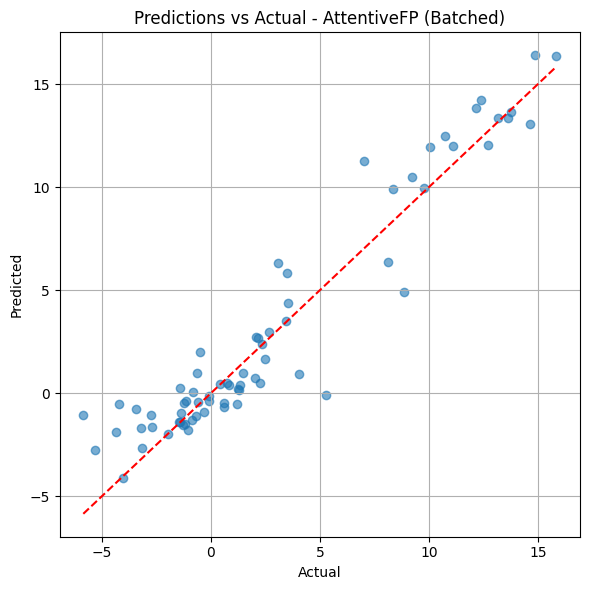

In [20]:
prediction_plot(model, loader)

In [21]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.metrics import r2_score, mean_squared_error
import torch

def plot_predictions_plotly(dataloader, model, metadata_df=None):
    """
    Function to plot predictions vs actual values using Plotly with hover tooltips.
    
    metadata_df: Optional DataFrame with molecule metadata.
                 Should have at least as many rows as total predictions.
                 Example columns: MoleculeName, SMILES, CAS.
    """
    
    model.eval()
    all_preds, all_targets = [], []

    with torch.no_grad():
        for batch in loader:
            out = model(batch).squeeze()
            y = batch.y.squeeze()
            all_preds.append(out.cpu())
            all_targets.append(y.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()

    
    # Compute metrics
    r2 = r2_score(all_targets, all_preds)
    rmse = np.sqrt(mean_squared_error(all_targets, all_preds))

    print(f"R² score: {r2:.3f}")
    print(f"RMSE: {rmse:.3f}")

    # Build DataFrame
    df = pd.DataFrame({
        "Actual": all_targets,
        "Predicted": all_preds
    })

    # Merge metadata if available
    if metadata_df is not None:
        metadata_df = metadata_df.reset_index(drop=True)
        df = pd.concat([df, metadata_df.iloc[:len(df)].reset_index(drop=True)], axis=1)

    # Make plot
    fig = px.scatter(
        df,
        x="Actual",
        y="Predicted",
        hover_data={
            "Inhibitor Name": True,
            "Inh Power": False, #':.2f',
            "CAS Number": False,
            "SMILES": False
        },
        title="Predicted vs Actual - AttentiveFP (Batched)",
        labels={"Actual": "Actual", "Predicted": "Predicted"},
        height=600,
        width=600
    )

    # Identity line y=x
    fig.add_shape(
        type="line",
        x0=df["Actual"].min(),
        y0=df["Actual"].min(),
        x1=df["Actual"].max(),
        y1=df["Actual"].max(),
        line=dict(color="red", dash="dash"),
    )

    fig.update_traces(marker=dict(size=8, opacity=0.7))
    fig.update_layout(showlegend=False)
    fig.show()


In [22]:
eval_loader = DataLoader(graph_list, batch_size=32, shuffle=False)
plot_predictions_plotly(eval_loader, model, metadata_df=molecules_df)

R² score: 0.907
RMSE: 1.726


## Predicting an arbitrary molecule

In [23]:
mol_to_predict = [graph_list[23]]
mol_to_predict[0].y

tensor([1.2800])

In [24]:
from torch_geometric.data import Batch

def predict_single_molecule(model, molecule_graph):
    model.eval()
    with torch.no_grad():
        batch = Batch.from_data_list([molecule_graph])  # wrap in a list

        prediction = model(batch)

        return round(prediction.item(), 4) # scalar output

predicted_value = predict_single_molecule(model, mol_to_predict[0])
predicted_value

0.1755

## Effect of Training Parameters on model performance

Here, we will explore the effects of model training parameters (and small model changes) and how these affect model performance. Namely, we will explore the effects of:
* Number of layers used within the model
* Number of epochs used in training
* Learning rate
* Dropout rate


### Number of Layers

In [25]:
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import torch

def r2_rmse(dataloader, model):
    """
    Function to plot predictions vs actual values.
    This function however returns the R² score and RMSE.
    """

    # Put model in evaluation mode
    model.eval()
    preds, targets = [], []

    with torch.no_grad():
        for batch in loader:
            out = model(batch).squeeze()
            y = batch.y.squeeze()
            preds.append(out.cpu())
            targets.append(y.cpu())

    preds = torch.cat(preds).numpy()
    targets = torch.cat(targets).numpy()

    # COmpute metrics
    r2 = r2_score(targets, preds)
    rmse = np.sqrt(mean_squared_error(targets, preds))

    print(f"R²: {r2_score(targets, preds):.3f}")
    print(f"RMSE: {root_mean_squared_error(targets, preds):.3f}")
    
    return r2, rmse



In [26]:
metrics_layers = {}

#### 1 Layer

In [27]:
import torch
from torch.nn import Linear, ReLU, Dropout, Sequential
from torch_geometric.nn import AttentiveFP

class AttentiveFPModel1L(torch.nn.Module):
    def __init__(self, node_dim, edge_dim, hidden_dim, out_dim, num_layers=1, timesteps=2, dropout_rate=0.2):
        super().__init__()

        self.attentivefp = AttentiveFP(
            in_channels=node_dim,
            hidden_channels=hidden_dim,
            out_channels=hidden_dim,  # should match Linear input
            edge_dim=edge_dim,
            num_layers=num_layers,
            num_timesteps=timesteps,
            dropout=dropout_rate
        )

        self.ffnn = Sequential(
            Linear(hidden_dim, hidden_dim),
            ReLU(),
            Dropout(dropout_rate),
            Linear(hidden_dim, out_dim)
        )

    def forward(self, data):
        x = self.attentivefp(data.x, data.edge_index, data.edge_attr, data.batch)
        return self.ffnn(x)


In [28]:
model_1L = AttentiveFPModel1L(
    node_dim=num_node_features,
    edge_dim=num_edge_features,
    hidden_dim=64,
    out_dim=1)
print(model_1L)

AttentiveFPModel1L(
  (attentivefp): AttentiveFP(in_channels=79, hidden_channels=64, out_channels=64, edge_dim=10, num_layers=1, num_timesteps=2)
  (ffnn): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [29]:
train_attFP_model(model_1L, loader, lr=1e-3, epochs=300)
metrics_layers['1L'] = r2_rmse(loader, model_1L)
metrics_layers

Epoch 1, Loss : 110.2129
Epoch 2, Loss : 96.3777
Epoch 3, Loss : 91.6382
Epoch 4, Loss : 94.7581
Epoch 5, Loss : 107.6163
Epoch 6, Loss : 102.9528
Epoch 7, Loss : 110.8601
Epoch 8, Loss : 117.1909
Epoch 9, Loss : 84.7457
Epoch 10, Loss : 88.4453
Epoch 11, Loss : 103.5601
Epoch 12, Loss : 90.4483
Epoch 13, Loss : 82.4187
Epoch 14, Loss : 124.4611
Epoch 15, Loss : 91.1901
Epoch 16, Loss : 93.3268
Epoch 17, Loss : 116.7670
Epoch 18, Loss : 93.9837
Epoch 19, Loss : 96.3488
Epoch 20, Loss : 78.9139
Epoch 21, Loss : 99.4832
Epoch 22, Loss : 94.3337
Epoch 23, Loss : 90.4282
Epoch 24, Loss : 85.8378
Epoch 25, Loss : 77.9609
Epoch 26, Loss : 69.4418
Epoch 27, Loss : 122.4986
Epoch 28, Loss : 87.4168
Epoch 29, Loss : 79.6947
Epoch 30, Loss : 98.0227
Epoch 31, Loss : 81.3633
Epoch 32, Loss : 67.4560
Epoch 33, Loss : 72.0430
Epoch 34, Loss : 90.1504
Epoch 35, Loss : 63.0055
Epoch 36, Loss : 68.4636
Epoch 37, Loss : 65.6385
Epoch 38, Loss : 76.6406
Epoch 39, Loss : 72.2949
Epoch 40, Loss : 82.5663


{'1L': (0.8553103804588318, np.float64(2.153953988394054))}

#### 2 Layers

In [30]:
import torch
from torch.nn import Linear, ReLU, Dropout, Sequential
from torch_geometric.nn import AttentiveFP

class AttentiveFPModel2L(torch.nn.Module):
    def __init__(self, node_dim, edge_dim, hidden_dim, out_dim, num_layers=2, timesteps=2, dropout_rate=0.2):
        super().__init__()

        self.attentivefp = AttentiveFP(
            in_channels=node_dim,
            hidden_channels=hidden_dim,
            out_channels=hidden_dim,  # should match Linear input
            edge_dim=edge_dim,
            num_layers=num_layers,
            num_timesteps=timesteps,
            dropout=dropout_rate
        )

        self.ffnn = Sequential(
            Linear(hidden_dim, hidden_dim),
            ReLU(),
            Dropout(dropout_rate),
            Linear(hidden_dim, out_dim)
        )

    def forward(self, data):
        x = self.attentivefp(data.x, data.edge_index, data.edge_attr, data.batch)
        return self.ffnn(x)


In [31]:
model_2L = AttentiveFPModel2L(
    node_dim=num_node_features,
    edge_dim=num_edge_features,
    hidden_dim=64,
    out_dim=1)
print(model_2L)

AttentiveFPModel2L(
  (attentivefp): AttentiveFP(in_channels=79, hidden_channels=64, out_channels=64, edge_dim=10, num_layers=2, num_timesteps=2)
  (ffnn): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)


Epoch 1, Loss : 126.3412
Epoch 2, Loss : 121.5478
Epoch 3, Loss : 97.3443
Epoch 4, Loss : 135.1544
Epoch 5, Loss : 114.7273
Epoch 6, Loss : 95.0325
Epoch 7, Loss : 87.8525
Epoch 8, Loss : 129.6968
Epoch 9, Loss : 98.6937
Epoch 10, Loss : 105.0123
Epoch 11, Loss : 90.6449
Epoch 12, Loss : 112.5608
Epoch 13, Loss : 85.1056
Epoch 14, Loss : 95.7928
Epoch 15, Loss : 79.6832
Epoch 16, Loss : 112.1450
Epoch 17, Loss : 101.9584
Epoch 18, Loss : 84.8673
Epoch 19, Loss : 90.2933
Epoch 20, Loss : 82.1547
Epoch 21, Loss : 74.2794
Epoch 22, Loss : 98.2120
Epoch 23, Loss : 92.0271
Epoch 24, Loss : 78.0505
Epoch 25, Loss : 99.2039
Epoch 26, Loss : 87.6990
Epoch 27, Loss : 76.5262
Epoch 28, Loss : 78.1939
Epoch 29, Loss : 94.8268
Epoch 30, Loss : 110.4729
Epoch 31, Loss : 79.4757
Epoch 32, Loss : 69.9434
Epoch 33, Loss : 62.6636
Epoch 34, Loss : 81.7085
Epoch 35, Loss : 67.0841
Epoch 36, Loss : 73.3633
Epoch 37, Loss : 67.5799
Epoch 38, Loss : 66.2465
Epoch 39, Loss : 81.9569
Epoch 40, Loss : 75.6062

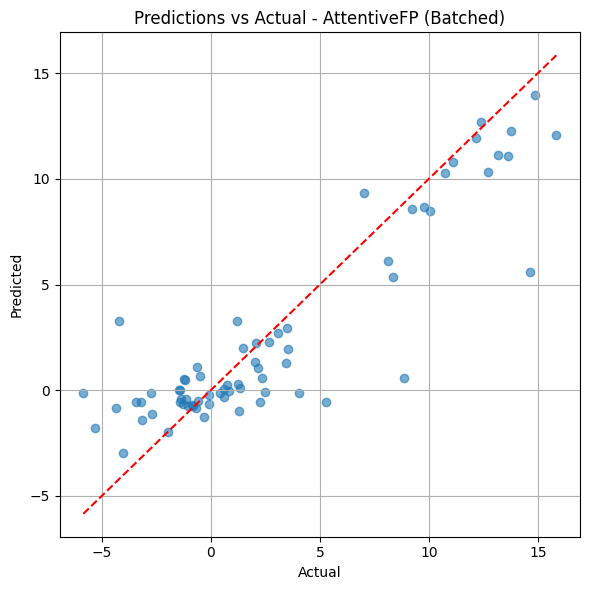

R²: 0.795
RMSE: 2.567


In [32]:
train_attFP_model(model_2L, loader, lr=1e-3, epochs=300)
prediction_plot(model_2L, loader)
metrics_layers['2L'] = r2_rmse(loader, model_2L)

#### 3 Layers

In [33]:
import torch
from torch.nn import Linear, ReLU, Dropout, Sequential
from torch_geometric.nn import AttentiveFP

class AttentiveFPModel3L(torch.nn.Module):
    def __init__(self, node_dim, edge_dim, hidden_dim, out_dim, num_layers=3, timesteps=2, dropout_rate=0.2):
        super().__init__()

        self.attentivefp = AttentiveFP(
            in_channels=node_dim,
            hidden_channels=hidden_dim,
            out_channels=hidden_dim,  # should match Linear input
            edge_dim=edge_dim,
            num_layers=num_layers,
            num_timesteps=timesteps,
            dropout=dropout_rate
        )

        self.ffnn = Sequential(
            Linear(hidden_dim, hidden_dim),
            ReLU(),
            Dropout(dropout_rate),
            Linear(hidden_dim, out_dim)
        )

    def forward(self, data):
        x = self.attentivefp(data.x, data.edge_index, data.edge_attr, data.batch)
        return self.ffnn(x)


In [34]:
model_3L = AttentiveFPModel3L(
    node_dim=num_node_features,
    edge_dim=num_edge_features,
    hidden_dim=64,
    out_dim=1)
print(model_3L)

AttentiveFPModel3L(
  (attentivefp): AttentiveFP(in_channels=79, hidden_channels=64, out_channels=64, edge_dim=10, num_layers=3, num_timesteps=2)
  (ffnn): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)


Epoch 1, Loss : 92.1735
Epoch 2, Loss : 116.1399
Epoch 3, Loss : 122.2846
Epoch 4, Loss : 147.5819
Epoch 5, Loss : 97.4542
Epoch 6, Loss : 96.0694
Epoch 7, Loss : 99.3598
Epoch 8, Loss : 89.5871
Epoch 9, Loss : 87.4005
Epoch 10, Loss : 95.0747
Epoch 11, Loss : 80.8860
Epoch 12, Loss : 111.5546
Epoch 13, Loss : 76.6735
Epoch 14, Loss : 90.1879
Epoch 15, Loss : 100.1229
Epoch 16, Loss : 84.6802
Epoch 17, Loss : 92.3795
Epoch 18, Loss : 87.7497
Epoch 19, Loss : 78.4379
Epoch 20, Loss : 121.9823
Epoch 21, Loss : 90.2253
Epoch 22, Loss : 100.8666
Epoch 23, Loss : 104.9722
Epoch 24, Loss : 87.0044
Epoch 25, Loss : 114.3982
Epoch 26, Loss : 80.4318
Epoch 27, Loss : 76.7061
Epoch 28, Loss : 98.1054
Epoch 29, Loss : 84.6731
Epoch 30, Loss : 91.5732
Epoch 31, Loss : 98.5010
Epoch 32, Loss : 94.8636
Epoch 33, Loss : 75.1201
Epoch 34, Loss : 85.2699
Epoch 35, Loss : 80.0699
Epoch 36, Loss : 70.2853
Epoch 37, Loss : 71.5019
Epoch 38, Loss : 60.4246
Epoch 39, Loss : 79.6887
Epoch 40, Loss : 62.0100


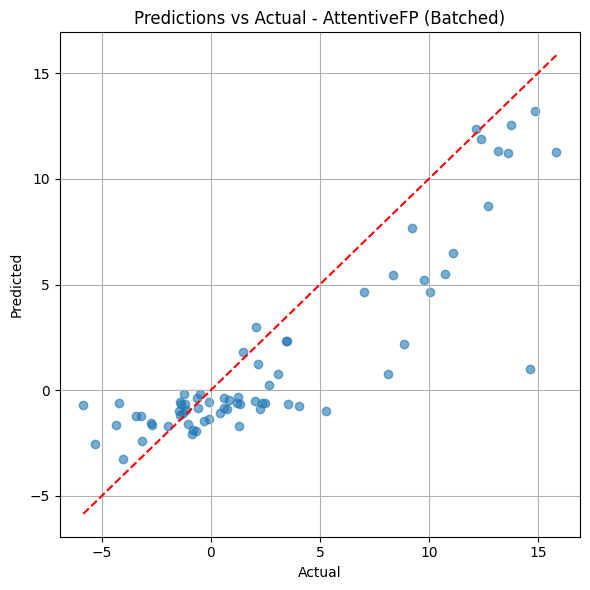

R²: 0.694
RMSE: 3.133


In [35]:
train_attFP_model(model_3L, loader, lr=1e-3, epochs=300)
prediction_plot(model_3L, loader)
metrics_layers['3L'] = r2_rmse(loader, model_3L)

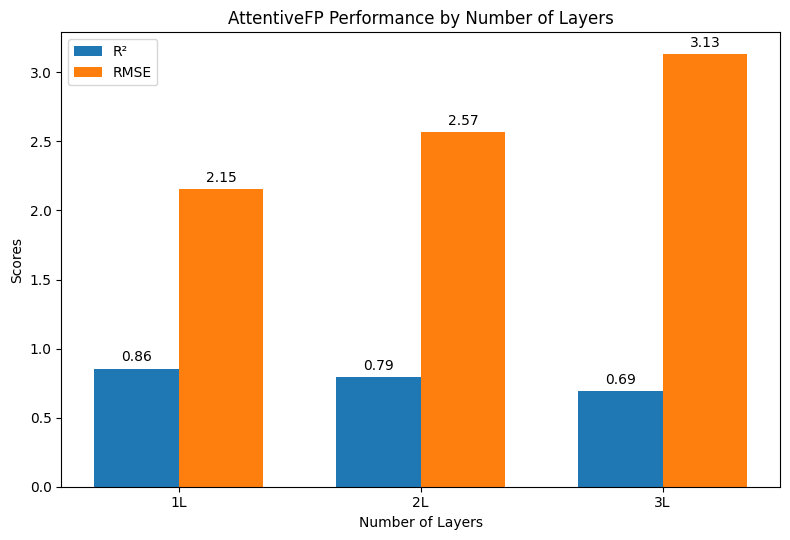

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Extract labels and scores
labels = list(metrics_layers.keys())
r2_scores = [v[0] for v in metrics_layers.values()]
rmse_scores = [v[1] for v in metrics_layers.values()]

# X positions for each group
x = np.arange(len(labels))

# Bar width
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5.5))

# Bars for R2
bars1 = ax.bar(x - width/2, r2_scores, width, label='R²')

# Bars for RMSE
bars2 = ax.bar(x + width/2, rmse_scores, width, label='RMSE')

# Labels and formatting
ax.set_xlabel('Number of Layers')
ax.set_ylabel('Scores')
ax.set_title('AttentiveFP Performance by Number of Layers')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Optionally add value labels on top
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

plt.tight_layout()
plt.show()


### Number of epochs

In [37]:
train_epochs = [100, 200, 300, 400, 500]
metrics_epoch = {}
for epoch in train_epochs:
    model_epoch = AttentiveFPModel2L(node_dim=num_node_features, edge_dim=num_edge_features, hidden_dim=64, out_dim=1)
    train_attFP_model(model_epoch, loader, lr=1e-3, epochs=300)
    metrics_epoch[epoch] = r2_rmse(loader, model_epoch)
metrics_epoch

Epoch 1, Loss : 104.0267
Epoch 2, Loss : 111.9406
Epoch 3, Loss : 110.9827
Epoch 4, Loss : 121.6594
Epoch 5, Loss : 90.8922
Epoch 6, Loss : 128.8036
Epoch 7, Loss : 92.0244
Epoch 8, Loss : 92.5816
Epoch 9, Loss : 120.2259
Epoch 10, Loss : 101.2394
Epoch 11, Loss : 91.9051
Epoch 12, Loss : 155.0285
Epoch 13, Loss : 100.7481
Epoch 14, Loss : 136.0838
Epoch 15, Loss : 78.4821
Epoch 16, Loss : 75.1004
Epoch 17, Loss : 109.6332
Epoch 18, Loss : 90.4690
Epoch 19, Loss : 90.7873
Epoch 20, Loss : 83.1786
Epoch 21, Loss : 101.9813
Epoch 22, Loss : 116.8090
Epoch 23, Loss : 67.5731
Epoch 24, Loss : 92.9150
Epoch 25, Loss : 82.6935
Epoch 26, Loss : 94.8841
Epoch 27, Loss : 82.0967
Epoch 28, Loss : 76.7228
Epoch 29, Loss : 88.0600
Epoch 30, Loss : 87.8634
Epoch 31, Loss : 85.1517
Epoch 32, Loss : 84.5054
Epoch 33, Loss : 81.6911
Epoch 34, Loss : 60.5731
Epoch 35, Loss : 59.3301
Epoch 36, Loss : 64.2427
Epoch 37, Loss : 81.1075
Epoch 38, Loss : 68.3284
Epoch 39, Loss : 88.5378
Epoch 40, Loss : 124.

{100: (0.8351932764053345, np.float64(2.2988212799255567)),
 200: (0.8557472229003906, np.float64(2.150699825387569)),
 300: (0.811631977558136, np.float64(2.4576573385357134)),
 400: (0.8287022113800049, np.float64(2.3436546814927244)),
 500: (0.8702284693717957, np.float64(2.0398930871286574))}

In [38]:
for key, value in metrics_epoch.items():
    print(f"Epoch: {key}, R²: {value[0]:.3f}, RMSE: {value[1]:.3f}")

Epoch: 100, R²: 0.835, RMSE: 2.299
Epoch: 200, R²: 0.856, RMSE: 2.151
Epoch: 300, R²: 0.812, RMSE: 2.458
Epoch: 400, R²: 0.829, RMSE: 2.344
Epoch: 500, R²: 0.870, RMSE: 2.040


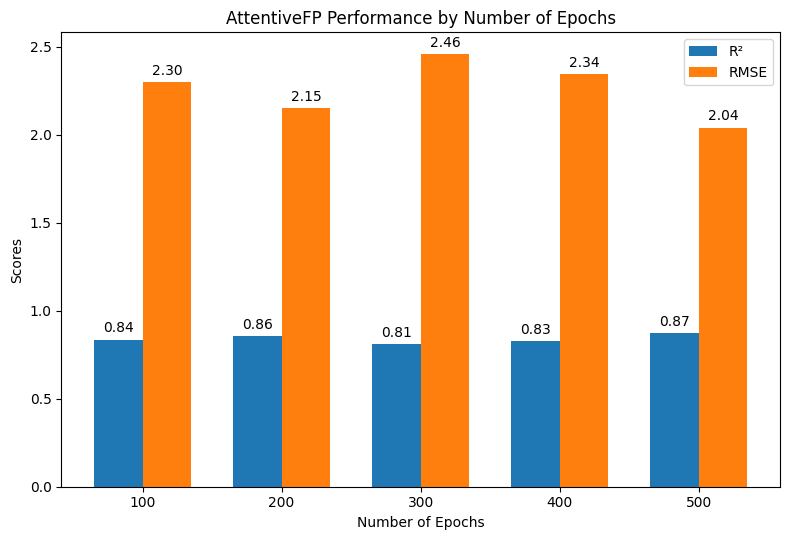

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Extract labels and scores
labels = list(metrics_epoch.keys())
r2_scores = [v[0] for v in metrics_epoch.values()]
rmse_scores = [v[1] for v in metrics_epoch.values()]

# X positions for each group
x = np.arange(len(labels))

# Bar width
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5.5))

# Bars for R2
bars1 = ax.bar(x - width/2, r2_scores, width, label='R²')

# Bars for RMSE
bars2 = ax.bar(x + width/2, rmse_scores, width, label='RMSE')

# Labels and formatting
ax.set_xlabel('Number of Epochs')
ax.set_ylabel('Scores')
ax.set_title('AttentiveFP Performance by Number of Epochs')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Optionally add value labels on top
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

plt.tight_layout()
plt.show()


### Dropout Rates

In [40]:
dropout_rates = [0.1, 0.2, 0.3, 0.4, 0.5]
metrics_dropout = {}
for dr in dropout_rates:
    model_dr = AttentiveFPModel2L(node_dim=num_node_features, edge_dim=num_edge_features, hidden_dim=64, out_dim=1, dropout_rate=dr)
    train_attFP_model(model_dr, loader, lr=1e-3, epochs=300)
    metrics_dropout[dr] = r2_rmse(loader, model_dr)
metrics_dropout

Epoch 1, Loss : 155.7522
Epoch 2, Loss : 105.6857
Epoch 3, Loss : 101.2673
Epoch 4, Loss : 90.8083
Epoch 5, Loss : 104.6548
Epoch 6, Loss : 96.0087
Epoch 7, Loss : 83.4905
Epoch 8, Loss : 123.8309
Epoch 9, Loss : 118.2563
Epoch 10, Loss : 106.4692
Epoch 11, Loss : 89.1711
Epoch 12, Loss : 78.7516
Epoch 13, Loss : 100.6846
Epoch 14, Loss : 81.9207
Epoch 15, Loss : 100.4281
Epoch 16, Loss : 85.3321
Epoch 17, Loss : 84.2218
Epoch 18, Loss : 123.7458
Epoch 19, Loss : 88.9236
Epoch 20, Loss : 86.0863
Epoch 21, Loss : 102.5778
Epoch 22, Loss : 73.8944
Epoch 23, Loss : 102.9660
Epoch 24, Loss : 73.1677
Epoch 25, Loss : 70.3517
Epoch 26, Loss : 73.3168
Epoch 27, Loss : 106.5812
Epoch 28, Loss : 90.9000
Epoch 29, Loss : 94.3612
Epoch 30, Loss : 62.0838
Epoch 31, Loss : 105.6449
Epoch 32, Loss : 73.3385
Epoch 33, Loss : 68.9503
Epoch 34, Loss : 64.8373
Epoch 35, Loss : 73.6367
Epoch 36, Loss : 61.6918
Epoch 37, Loss : 50.6283
Epoch 38, Loss : 58.6623
Epoch 39, Loss : 56.9464
Epoch 40, Loss : 45.

{0.1: (0.8890016078948975, np.float64(1.88658353269668)),
 0.2: (0.7592335939407349, np.float64(2.7785338951570964)),
 0.3: (0.7398427128791809, np.float64(2.8882563603602818)),
 0.4: (0.76799476146698, np.float64(2.727511615116552)),
 0.5: (0.7562640905380249, np.float64(2.7956158238342863))}

In [41]:
for key, value in metrics_dropout.items():
    print(f"Dropout Rate: {key}, R²: {value[0]:.3f}, RMSE: {value[1]:.3f}")

Dropout Rate: 0.1, R²: 0.889, RMSE: 1.887
Dropout Rate: 0.2, R²: 0.759, RMSE: 2.779
Dropout Rate: 0.3, R²: 0.740, RMSE: 2.888
Dropout Rate: 0.4, R²: 0.768, RMSE: 2.728
Dropout Rate: 0.5, R²: 0.756, RMSE: 2.796


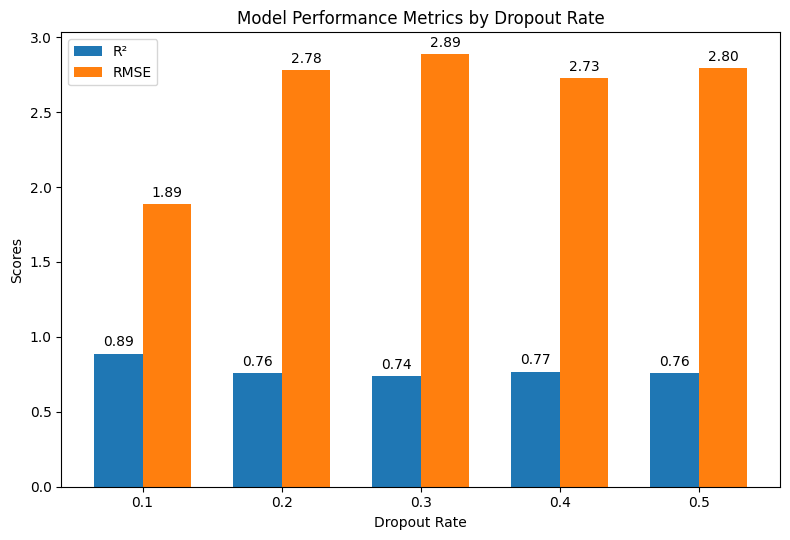

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Extract labels and scores
labels = list(metrics_dropout.keys())
r2_scores = [v[0] for v in metrics_dropout.values()]
rmse_scores = [v[1] for v in metrics_dropout.values()]

# X positions for each group
x = np.arange(len(labels))

# Bar width
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5.5))

# Bars for R2
bars1 = ax.bar(x - width/2, r2_scores, width, label='R²')

# Bars for RMSE
bars2 = ax.bar(x + width/2, rmse_scores, width, label='RMSE')

# Labels and formatting
ax.set_xlabel('Dropout Rate')
ax.set_ylabel('Scores')
ax.set_title('Model Performance Metrics by Dropout Rate')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Optionally add value labels on top
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

plt.tight_layout()
plt.show()


### Learning Rates

In [43]:
learning_rates = [0.1, 0.01, 1e-3, 1e-4, 1e-5]
metrics_lr = {}
for lr in learning_rates:
    model_lr = AttentiveFPModel2L(node_dim=num_node_features, edge_dim=num_edge_features, hidden_dim=64, out_dim=1)
    train_attFP_model(model_lr, loader, lr=lr, epochs=300)
    metrics_lr[lr] = r2_rmse(loader, model_lr)
metrics_lr

Epoch 1, Loss : 944.0510
Epoch 2, Loss : 18079.1113
Epoch 3, Loss : 846.5173
Epoch 4, Loss : 568.0068
Epoch 5, Loss : 535.9016
Epoch 6, Loss : 243.6890
Epoch 7, Loss : 239.8731
Epoch 8, Loss : 157.1854
Epoch 9, Loss : 932.9171
Epoch 10, Loss : 807.0157
Epoch 11, Loss : 719.1810
Epoch 12, Loss : 382.2106
Epoch 13, Loss : 3322.7938
Epoch 14, Loss : 132.7268
Epoch 15, Loss : 135.7528
Epoch 16, Loss : 96.9367
Epoch 17, Loss : 94.3822
Epoch 18, Loss : 141.9266
Epoch 19, Loss : 123.8875
Epoch 20, Loss : 116.2957
Epoch 21, Loss : 118.0724
Epoch 22, Loss : 109.8775
Epoch 23, Loss : 99.7700
Epoch 24, Loss : 106.3858
Epoch 25, Loss : 112.9924
Epoch 26, Loss : 118.1105
Epoch 27, Loss : 86.9828
Epoch 28, Loss : 86.3656
Epoch 29, Loss : 102.2562
Epoch 30, Loss : 100.9392
Epoch 31, Loss : 86.5888
Epoch 32, Loss : 95.6404
Epoch 33, Loss : 80.1792
Epoch 34, Loss : 104.7403
Epoch 35, Loss : 91.5084
Epoch 36, Loss : 125.5030
Epoch 37, Loss : 117.2628
Epoch 38, Loss : 100.1486
Epoch 39, Loss : 87.6378
Ep

{0.1: (-0.00023996829986572266, np.float64(5.663303424351333)),
 0.01: (0.6914348006248474, np.float64(3.1455109959526735)),
 0.001: (0.8639520406723022, np.float64(2.0886409542491027)),
 0.0001: (0.533075213432312, np.float64(3.869377980083981)),
 1e-05: (-0.10023868083953857, np.float64(5.939654471369342))}

In [44]:
for key, value in metrics_lr.items():
    print(f"Dropout Rate: {key}, R²: {value[0]:.3f}, RMSE: {value[1]:.3f}")

Dropout Rate: 0.1, R²: -0.000, RMSE: 5.663
Dropout Rate: 0.01, R²: 0.691, RMSE: 3.146
Dropout Rate: 0.001, R²: 0.864, RMSE: 2.089
Dropout Rate: 0.0001, R²: 0.533, RMSE: 3.869
Dropout Rate: 1e-05, R²: -0.100, RMSE: 5.940


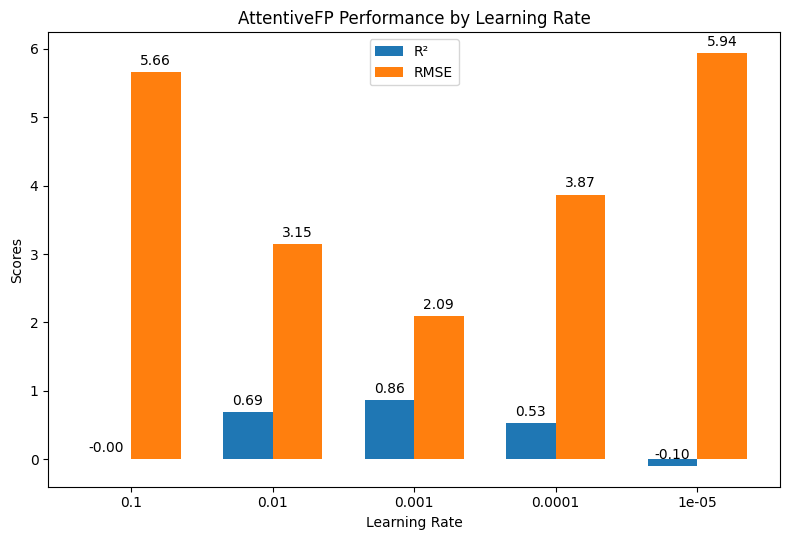

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Extract labels and scores
labels = list(metrics_lr.keys())
r2_scores = [v[0] for v in metrics_lr.values()]
rmse_scores = [v[1] for v in metrics_lr.values()]

# X positions for each group
x = np.arange(len(labels))

# Bar width
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5.5))

# Bars for R2
bars1 = ax.bar(x - width/2, r2_scores, width, label='R²')

# Bars for RMSE
bars2 = ax.bar(x + width/2, rmse_scores, width, label='RMSE')

# Labels and formatting
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Scores')
ax.set_title('AttentiveFP Performance by Learning Rate')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Optionally add value labels on top
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

plt.tight_layout()
plt.show()


## Investigating the effect of batching

In [46]:
batches = [1, 2, 4, 8, 16, 32, 64, 70]
metrics_batches = {}
for batch_size in batches:
    print(f"Training w/ Batch Size: {batch_size}")
    train_loader = DataLoader(graph_list, batch_size=batch_size, shuffle=True)
    model_b = AttentiveFPModel2L(node_dim=num_node_features, edge_dim=num_edge_features, hidden_dim=64, out_dim=1)
    train_attFP_model(model_b, train_loader, lr=1e-3, epochs=300)
    metrics_batches[batch_size] = r2_rmse(train_loader, model_b)

Training w/ Batch Size: 1
Epoch 1, Loss : 2770.4687
Epoch 2, Loss : 2482.9415
Epoch 3, Loss : 2332.7534
Epoch 4, Loss : 2368.4065
Epoch 5, Loss : 2291.6273
Epoch 6, Loss : 2208.4136
Epoch 7, Loss : 1826.6535
Epoch 8, Loss : 1329.4521
Epoch 9, Loss : 1444.1112
Epoch 10, Loss : 1334.5642
Epoch 11, Loss : 1179.7453
Epoch 12, Loss : 1451.6022
Epoch 13, Loss : 1237.1722
Epoch 14, Loss : 1315.2740
Epoch 15, Loss : 1474.8460
Epoch 16, Loss : 1304.5234
Epoch 17, Loss : 1101.3919
Epoch 18, Loss : 1252.4175
Epoch 19, Loss : 1193.6888
Epoch 20, Loss : 1158.6622
Epoch 21, Loss : 1045.5938
Epoch 22, Loss : 1428.2456
Epoch 23, Loss : 1280.8029
Epoch 24, Loss : 1106.6398
Epoch 25, Loss : 1128.2949
Epoch 26, Loss : 1112.1629
Epoch 27, Loss : 1006.9431
Epoch 28, Loss : 1076.0004
Epoch 29, Loss : 924.1878
Epoch 30, Loss : 1025.8939
Epoch 31, Loss : 1039.9416
Epoch 32, Loss : 990.6099
Epoch 33, Loss : 1018.3303
Epoch 34, Loss : 852.3362
Epoch 35, Loss : 860.6159
Epoch 36, Loss : 812.9189
Epoch 37, Loss :

In [47]:
metrics_batches

{1: (0.9498066902160645, np.float64(1.268646401370936)),
 2: (0.9802418947219849, np.float64(0.7959580849605515)),
 4: (0.9741887450218201, np.float64(0.9097503280827748)),
 8: (0.8586155772209167, np.float64(2.129210172185082)),
 16: (0.9593939185142517, np.float64(1.1410725904203385)),
 32: (0.8403609991073608, np.float64(2.2624929944346177)),
 64: (0.7503764629364014, np.float64(2.8291792616940703)),
 70: (0.7836410403251648, np.float64(2.633935705734086))}

In [48]:
for key, value in metrics_batches.items():
    print(f"Batch Size: {key}, R²: {value[0]:.3f}, RMSE: {value[1]:.3f}")

Batch Size: 1, R²: 0.950, RMSE: 1.269
Batch Size: 2, R²: 0.980, RMSE: 0.796
Batch Size: 4, R²: 0.974, RMSE: 0.910
Batch Size: 8, R²: 0.859, RMSE: 2.129
Batch Size: 16, R²: 0.959, RMSE: 1.141
Batch Size: 32, R²: 0.840, RMSE: 2.262
Batch Size: 64, R²: 0.750, RMSE: 2.829
Batch Size: 70, R²: 0.784, RMSE: 2.634


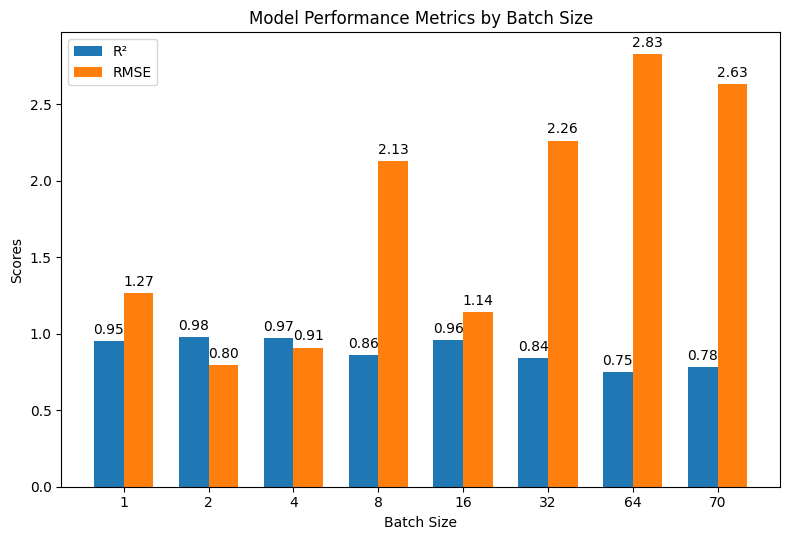

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# Extract labels and scores
labels = list(metrics_batches.keys())
r2_scores = [v[0] for v in metrics_batches.values()]
rmse_scores = [v[1] for v in metrics_batches.values()]

# X positions for each group
x = np.arange(len(labels))

# Bar width
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5.5))

# Bars for R2
bars1 = ax.bar(x - width/2, r2_scores, width, label='R²')

# Bars for RMSE
bars2 = ax.bar(x + width/2, rmse_scores, width, label='RMSE')

# Labels and formatting
ax.set_xlabel('Batch Size')
ax.set_ylabel('Scores')
ax.set_title('Model Performance Metrics by Batch Size')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Optionally add value labels on top
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

plt.tight_layout()
plt.show()
